<a href="https://colab.research.google.com/github/nbalatamu/HDM-for-Species-Dynamics/blob/main/Custom_Linear_Layer_for_Neg_Diag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math

In [ ]:
# Custom linear layer with Gaussian initialization
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, mu=0.0, sigma=1.0):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.diagonal_weight = nn.Parameter(torch.Tensor(min(in_features, out_features)))
        self.mu = mu
        self.sigma = sigma
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.weight, mean=self.mu, std=self.sigma)
        nn.init.normal_(self.diagonal_weight, mean=self.mu, std=self.sigma)  # Initialize normally with given mean and std
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        weight = self.get_weight()
        return F.linear(input, weight, self.bias)

    def get_weight(self):
        weight = self.weight.clone()
        diagonal_indices = torch.arange(min(self.in_features, self.out_features))
        weight[diagonal_indices, diagonal_indices] = -torch.exp(self.diagonal_weight)
        return weight

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, mu={}, sigma={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.mu, self.sigma
        )

In [ ]:
# Simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, mu=0.0, sigma=1.0):
        super(SimpleNN, self).__init__()
        self.fc = CustomLinear(2, 2, mu=mu, sigma=sigma)

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Generate data
def generate_data(num_samples=100):
    x = torch.randn(num_samples, 2)
    A = torch.tensor([[-2.5, 1.2], [1.6, -3.0]])
    b = torch.tensor([1.0, 2.7])
    y = x @ A.T + b
    return x, y

x, y = generate_data()

Epoch [100/1000], Loss: 0.8774
Epoch [200/1000], Loss: 0.2174
Epoch [300/1000], Loss: 0.0570
Epoch [400/1000], Loss: 0.0154
Epoch [500/1000], Loss: 0.0042
Epoch [600/1000], Loss: 0.0012
Epoch [700/1000], Loss: 0.0003
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


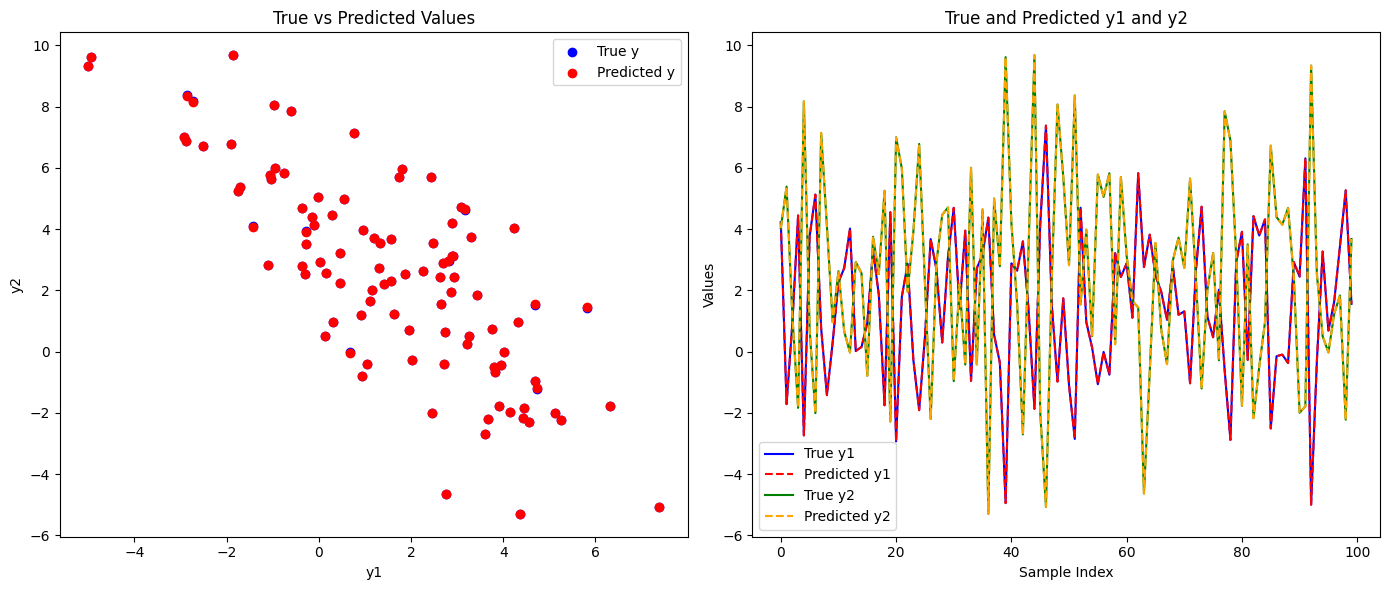

Learnt weight matrix:
 [[-2.5000248  1.1999396]
 [ 1.5962996 -2.9998739]]
Expected weight matrix:
 tensor([[-2.5000,  1.2000],
        [ 1.6000, -3.0000]])
Learnt bias:
 [0.9999144 2.6973586]
Expected bias:
 tensor([1.0000, 2.7000])


In [ ]:
# Initialize model, loss function, and optimizer
mu = 0.0  # Mean for Gaussian initialization
sigma = 0.1  # Standard deviation for Gaussian initialization
model = SimpleNN(mu=mu, sigma=sigma)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
predictions = model(x).detach().numpy()
true_values = y.numpy()

# Plot results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(true_values[:, 0], true_values[:, 1], label='True y', color='blue')
plt.scatter(predictions[:, 0], predictions[:, 1], label='Predicted y', color='red')
plt.xlabel('y1')
plt.ylabel('y2')
plt.legend()
plt.title('True vs Predicted Values')

plt.subplot(1, 2, 2)
plt.plot(true_values[:, 0], label='True y1', color='blue')
plt.plot(predictions[:, 0], label='Predicted y1', color='red', linestyle='--')
plt.plot(true_values[:, 1], label='True y2', color='green')
plt.plot(predictions[:, 1], label='Predicted y2', color='orange', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.title('True and Predicted y1 and y2')

plt.tight_layout()
plt.show()

# Print learnt parameters and expected parameters
learnt_weight = model.fc.get_weight().detach().numpy()
learnt_bias = model.fc.bias.detach().numpy()

expected_weight = torch.tensor([[-2.5, 1.2], [1.6, -3.0]])
expected_bias = torch.tensor([1.0, 2.7])

print('Learnt weight matrix:\n', learnt_weight)
print('Expected weight matrix:\n', expected_weight)

print('Learnt bias:\n', learnt_bias)
print('Expected bias:\n', expected_bias)


In [ ]:
# Generate data
def generate_data(num_samples=100):
    x = torch.randn(num_samples, 2)
    A = torch.tensor([[-2.5, 1.2], [1.6, 3.0]])
    b = torch.tensor([1.0, 2.7])
    y = x @ A.T + b
    return x, y

x, y = generate_data()

Epoch [100/1000], Loss: 6.3595
Epoch [200/1000], Loss: 5.4272
Epoch [300/1000], Loss: 5.2281
Epoch [400/1000], Loss: 5.1527
Epoch [500/1000], Loss: 5.1103
Epoch [600/1000], Loss: 5.0819
Epoch [700/1000], Loss: 5.0612
Epoch [800/1000], Loss: 5.0455
Epoch [900/1000], Loss: 5.0332
Epoch [1000/1000], Loss: 5.0232


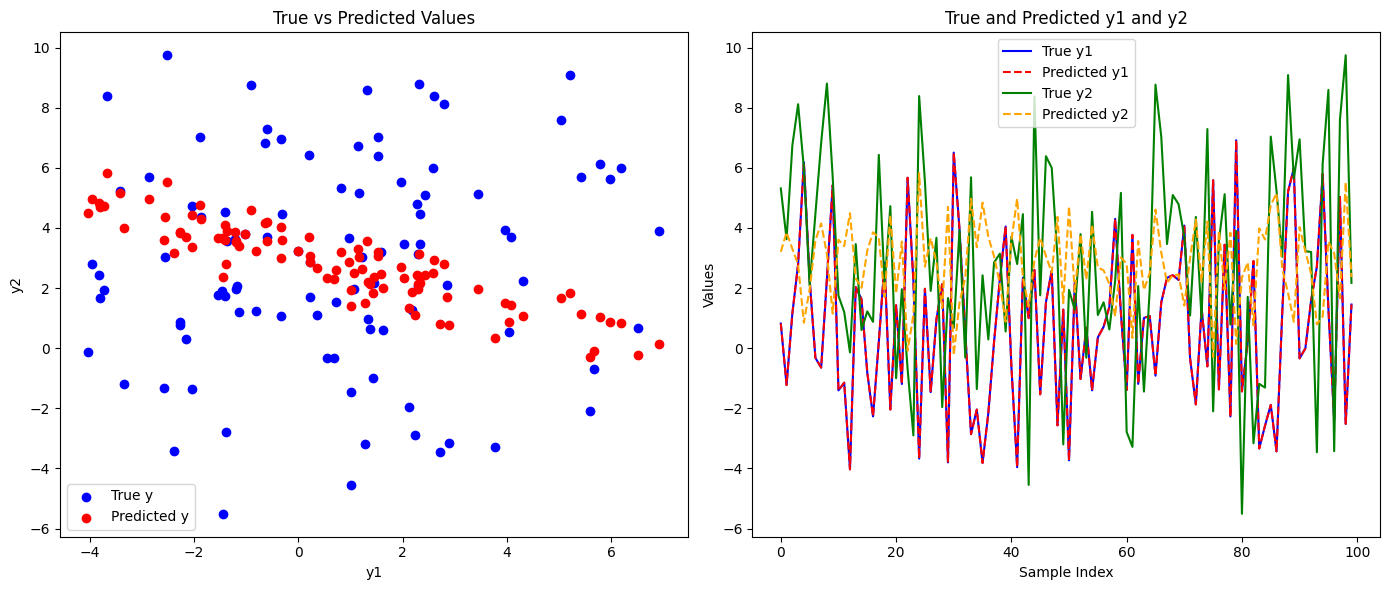

Learnt weight matrix:
 [[-2.4999936   1.1999781 ]
 [ 1.4341809  -0.02860397]]
Expected weight matrix:
 tensor([[-2.5000,  1.2000],
        [ 1.6000,  3.0000]])
Learnt bias:
 [0.99994564 2.6649382 ]
Expected bias:
 tensor([1.0000, 2.7000])


In [ ]:
# Initialize model, loss function, and optimizer
mu = 0.0  # Mean for Gaussian initialization
sigma = 0.1  # Standard deviation for Gaussian initialization
model = SimpleNN(mu=mu, sigma=sigma)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
predictions = model(x).detach().numpy()
true_values = y.numpy()

# Plot results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(true_values[:, 0], true_values[:, 1], label='True y', color='blue')
plt.scatter(predictions[:, 0], predictions[:, 1], label='Predicted y', color='red')
plt.xlabel('y1')
plt.ylabel('y2')
plt.legend()
plt.title('True vs Predicted Values')

plt.subplot(1, 2, 2)
plt.plot(true_values[:, 0], label='True y1', color='blue')
plt.plot(predictions[:, 0], label='Predicted y1', color='red', linestyle='--')
plt.plot(true_values[:, 1], label='True y2', color='green')
plt.plot(predictions[:, 1], label='Predicted y2', color='orange', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.title('True and Predicted y1 and y2')

plt.tight_layout()
plt.show()

# Print learnt parameters and expected parameters
learnt_weight = model.fc.get_weight().detach().numpy()
learnt_bias = model.fc.bias.detach().numpy()

expected_weight = torch.tensor([[-2.5, 1.2], [1.6, 3.0]])
expected_bias = torch.tensor([1.0, 2.7])

print('Learnt weight matrix:\n', learnt_weight)
print('Expected weight matrix:\n', expected_weight)

print('Learnt bias:\n', learnt_bias)
print('Expected bias:\n', expected_bias)


Epoch [100/1000], Loss: 0.7797
Weight matrix A at epoch 100:
[[-2.3848112   0.72165596]
 [ 1.0454465  -2.9258707 ]]

Epoch [200/1000], Loss: 0.1055
Weight matrix A at epoch 200:
[[-2.4826455  1.0233876]
 [ 1.3816059 -2.9746873]]

Epoch [300/1000], Loss: 0.0144
Weight matrix A at epoch 300:
[[-2.4937646  1.1348495]
 [ 1.5138081 -2.9903927]]

Epoch [400/1000], Loss: 0.0020
Weight matrix A at epoch 400:
[[-2.4977217  1.1759447]
 [ 1.5659102 -2.9963396]]

Epoch [500/1000], Loss: 0.0003
Weight matrix A at epoch 500:
[[-2.4991665  1.1911099]
 [ 1.5864897 -2.9986017]]

Epoch [600/1000], Loss: 0.0000
Weight matrix A at epoch 600:
[[-2.4996946  1.1967113]
 [ 1.5946355 -2.999464 ]]

Epoch [700/1000], Loss: 0.0000
Weight matrix A at epoch 700:
[[-2.4998882  1.1987821]
 [ 1.597866  -2.999794 ]]

Epoch [800/1000], Loss: 0.0000
Weight matrix A at epoch 800:
[[-2.4999588  1.1995486]
 [ 1.5991495 -2.9999197]]

Epoch [900/1000], Loss: 0.0000
Weight matrix A at epoch 900:
[[-2.499984   1.1998326]
 [ 1.5

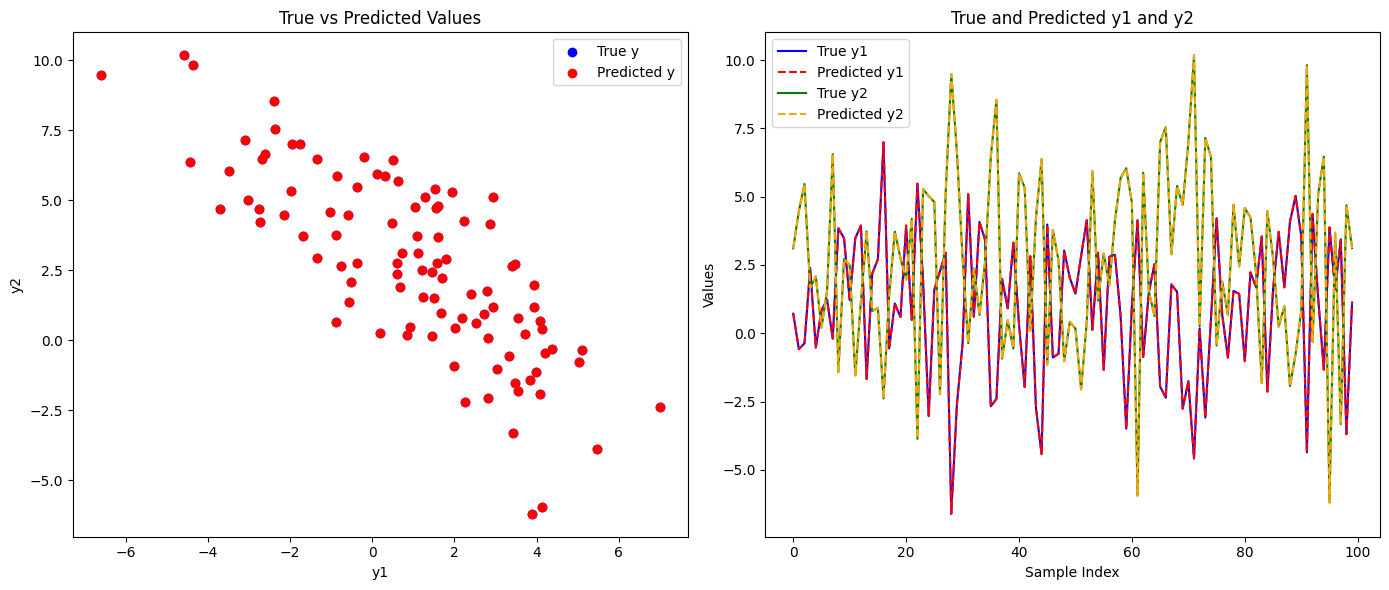

Learnt weight matrix:
 [[-2.499994   1.1999377]
 [ 1.5998644 -2.9999876]]
Expected weight matrix:
 tensor([[-2.5000,  1.2000],
        [ 1.6000, -3.0000]])
Learnt bias:
 [0.9999669 2.699906 ]
Expected bias:
 tensor([1.0000, 2.7000])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math

# Custom linear layer with Gaussian initialization
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, mu=0.0, sigma=1.0):
        super(CustomLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.diagonal_weight = nn.Parameter(torch.Tensor(min(in_features, out_features)))
        self.mu = mu
        self.sigma = sigma
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.weight, mean=self.mu, std=self.sigma)
        nn.init.normal_(self.diagonal_weight, mean=self.mu, std=self.sigma)  # Initialize normally with given mean and std
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        weight = self.get_weight()
        return F.linear(input, weight, self.bias)

    def get_weight(self):
        weight = self.weight.clone()
        diagonal_indices = torch.arange(min(self.in_features, self.out_features))
        weight[diagonal_indices, diagonal_indices] = -torch.exp(self.diagonal_weight)
        return weight

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, mu={}, sigma={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.mu, self.sigma
        )

# Simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, mu=0.0, sigma=1.0):
        super(SimpleNN, self).__init__()
        self.fc = CustomLinear(2, 2, mu=mu, sigma=sigma)

    def forward(self, x):
        return self.fc(x)

# Generate data
def generate_data(num_samples=100):
    x = torch.randn(num_samples, 2)
    A = torch.tensor([[-2.5, 1.2], [1.6, -3.0]])
    b = torch.tensor([1.0, 2.7])
    y = x @ A.T + b
    return x, y

x, y = generate_data()

# Initialize model, loss function, and optimizer
mu = 0.0  # Mean for Gaussian initialization
sigma = 0.1  # Standard deviation for Gaussian initialization
model = SimpleNN(mu=mu, sigma=sigma)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        current_weight = model.fc.get_weight().detach().numpy()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Weight matrix A at epoch {epoch+1}:\n{current_weight}\n')

# Make predictions
predictions = model(x).detach().numpy()
true_values = y.numpy()

# Plot results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(true_values[:, 0], true_values[:, 1], label='True y', color='blue')
plt.scatter(predictions[:, 0], predictions[:, 1], label='Predicted y', color='red')
plt.xlabel('y1')
plt.ylabel('y2')
plt.legend()
plt.title('True vs Predicted Values')

plt.subplot(1, 2, 2)
plt.plot(true_values[:, 0], label='True y1', color='blue')
plt.plot(predictions[:, 0], label='Predicted y1', color='red', linestyle='--')
plt.plot(true_values[:, 1], label='True y2', color='green')
plt.plot(predictions[:, 1], label='Predicted y2', color='orange', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.title('True and Predicted y1 and y2')

plt.tight_layout()
plt.show()

# Print learnt parameters and expected parameters
learnt_weight = model.fc.get_weight().detach().numpy()
learnt_bias = model.fc.bias.detach().numpy()

expected_weight = torch.tensor([[-2.5, 1.2], [1.6, -3.0]])
expected_bias = torch.tensor([1.0, 2.7])

print('Learnt weight matrix:\n', learnt_weight)
print('Expected weight matrix:\n', expected_weight)

print('Learnt bias:\n', learnt_bias)
print('Expected bias:\n', expected_bias)
